# Нейросеть СNN - LSTM для распознавания тематики книги по обложке

In [2]:
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Conv2D, BatchNormalization, AveragePooling2D, Flatten, TimeDistributed
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import re
from random import shuffle
from glob import glob
import pandas as pd

all_files = glob('allfiles\\*.jpg')

In [4]:
all_f = []
for i in all_files:
    all_f.append(i.replace('allfiles'+'\\',''))
ff = pd.DataFrame(all_f, columns=['fname'])

ff - датафрейм чтобы проверить, что есть все файлы из загруженной таблицы; пустые записи удалим.

загрузим заранее подготовленный файл с классами и номером изображения

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

df = pd.read_csv('title_cover.csv')
df['path'] = df.file.apply(lambda x: 'allfiles'+'\\'+x )
df.head()

,children,fantasy,medicine,music,mystery and detective stories,recipes,religion,romance,science,science fiction,cover_id,file,path
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575546.0,575546.jpg,allfiles\575546.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981419.0,1981419.jpg,allfiles\1981419.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905279.0,905279.jpg,allfiles\905279.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321813.0,1321813.jpg,allfiles\1321813.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964863.0,2964863.jpg,allfiles\2964863.jpg


In [6]:
books = df.merge(ff, left_on='file', right_on='fname', how='inner') 
# inner,  чтобы взять те файлы, которые точно есть и папке с файлами и в df

In [7]:
df_1 = books[['path','religion']][books.religion  == 1]
df_majority = books[['path','religion']][books.religion != 1]

In [8]:
# Downsample majority class
df_0 = resample(df_majority,replace=False,    # sample without replacement
                                 n_samples=int(df_1.shape[0]),     # to match minority class
                                 random_state=888) # reproducible results
df_downsampl = pd.concat([df_0, df_1])
df_downsampl.reset_index(inplace = True)
del df_downsampl['index']
X = df_downsampl['path']
y = df_downsampl['religion']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, shuffle = True)
    
ytr_bin = to_categorical(y_train)
ytst_bin = to_categorical(y_test)

In [10]:
Xtr, Xtst, ytr, ytst = list(np.array(X_train)), list(np.array(X_test)), np.array(y_train), np.array(y_test)

In [11]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [12]:
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для ResNet50

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, yy ,  batch_size = 32):    
    while True:
        #shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)               
                
            x = np.array([load_image(path) for path in files[i:j]])
            y = yy[i:j]
            #print(i, j)
            #print(len(x))
            #print(y)           
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

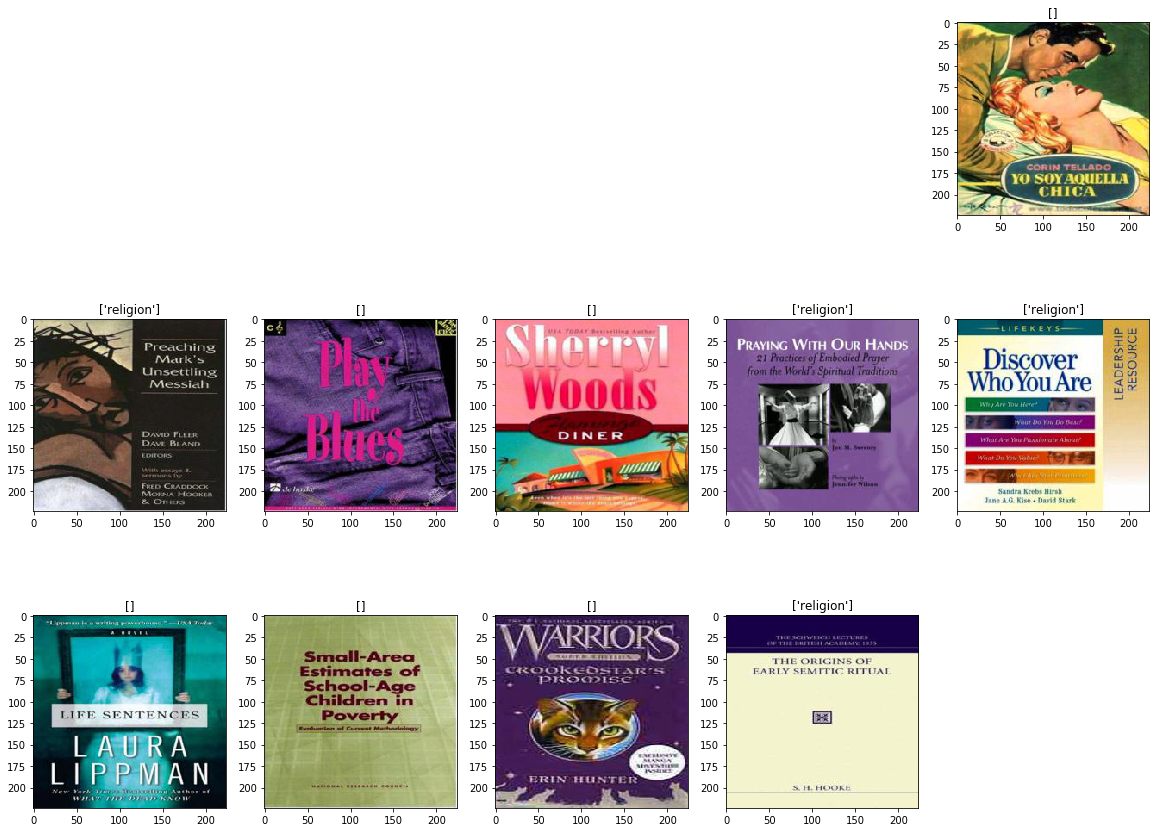

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    book_title = []
    if ytr[i] !=0:
            #print(j, subj_list[j])
        book_title.append('religion')
    subplot.set_title('%s' %  str(book_title)); # поправить вывод названия
    
plt.show()

In [14]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [15]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
#optimizer = RMSprop(1e-3)

In [16]:
x = base_model.output 
x = keras.layers.TimeDistributed(Flatten())(x)
x = keras.layers.LSTM(2048, input_shape=(2048,None), return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(1024,  return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(512, return_sequences=True, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(256, return_sequences=True, activation = 'relu') (x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.LSTM(128, activation = 'relu')(x)
x = keras.layers.Dropout(0.2) (x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                )(x) 

model = Model(inputs=base_model.input, outputs=x)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [21]:
model.compile(optimizer=RMSprop(1e-3), loss='binary_crossentropy',  metrics=['accuracy'])
checkp = ModelCheckpoint(filepath='weights_lstm_relig_2000 1 vers.best.cover.hdf5', 
                               verbose=1, save_best_only=True)

In [22]:
train_val_split = 100  # число изображений в валидационной выборке
validation_data = next(fit_generator(Xtr[:train_val_split],ytr[:train_val_split], train_val_split))
validation_data[1].shape

(100,)

In [23]:
# запускаем процесс обучения
model.fit_generator(fit_generator(Xtr[train_val_split:], ytr[train_val_split:], 100),  # данные читаем функцией-генератором
        steps_per_epoch=50,  # число вызовов генератора за эпоху
        epochs=20,  # число эпох обучения
        validation_data=validation_data, callbacks = [checkp])

Epoch 1/20
49/50 [============================>.] - ETA: 0s - loss: 0.7082 - acc: 0.5416
Epoch 00001: val_loss improved from inf to 0.69133, saving model to weights_lstm_relig_2000 1 vers.best.cover.hdf5
50/50 [==============================] - 46s 928ms/step - loss: 0.7079 - acc: 0.5406 - val_loss: 0.6913 - val_acc: 0.5700
Epoch 2/20
49/50 [============================>.] - ETA: 0s - loss: 0.6588 - acc: 0.6312
Epoch 00002: val_loss improved from 0.69133 to 0.65045, saving model to weights_lstm_relig_2000 1 vers.best.cover.hdf5
50/50 [==============================] - 25s 499ms/step - loss: 0.6585 - acc: 0.6332 - val_loss: 0.6505 - val_acc: 0.7100
Epoch 3/20
49/50 [============================>.] - ETA: 0s - loss: 0.6160 - acc: 0.6729
Epoch 00003: val_loss improved from 0.65045 to 0.59099, saving model to weights_lstm_relig_2000 1 vers.best.cover.hdf5
50/50 [==============================] - 25s 501ms/step - loss: 0.6140 - acc: 0.6740 - val_loss: 0.5910 - val_acc: 0.6700
Epoch 4/20
49/

In [24]:
%%time
pred = model.predict_generator(predict_generator(Xtst), len(ytst), max_queue_size=100)

Wall time: 52.9 s


In [65]:
pred

array([[9.9215746e-01],
       [5.5391436e-05],
       [7.5175065e-01],
       ...,
       [8.5255915e-01],
       [6.3263327e-01],
       [7.5781834e-01]], dtype=float32)

In [37]:
y_pred= np.round(pred)

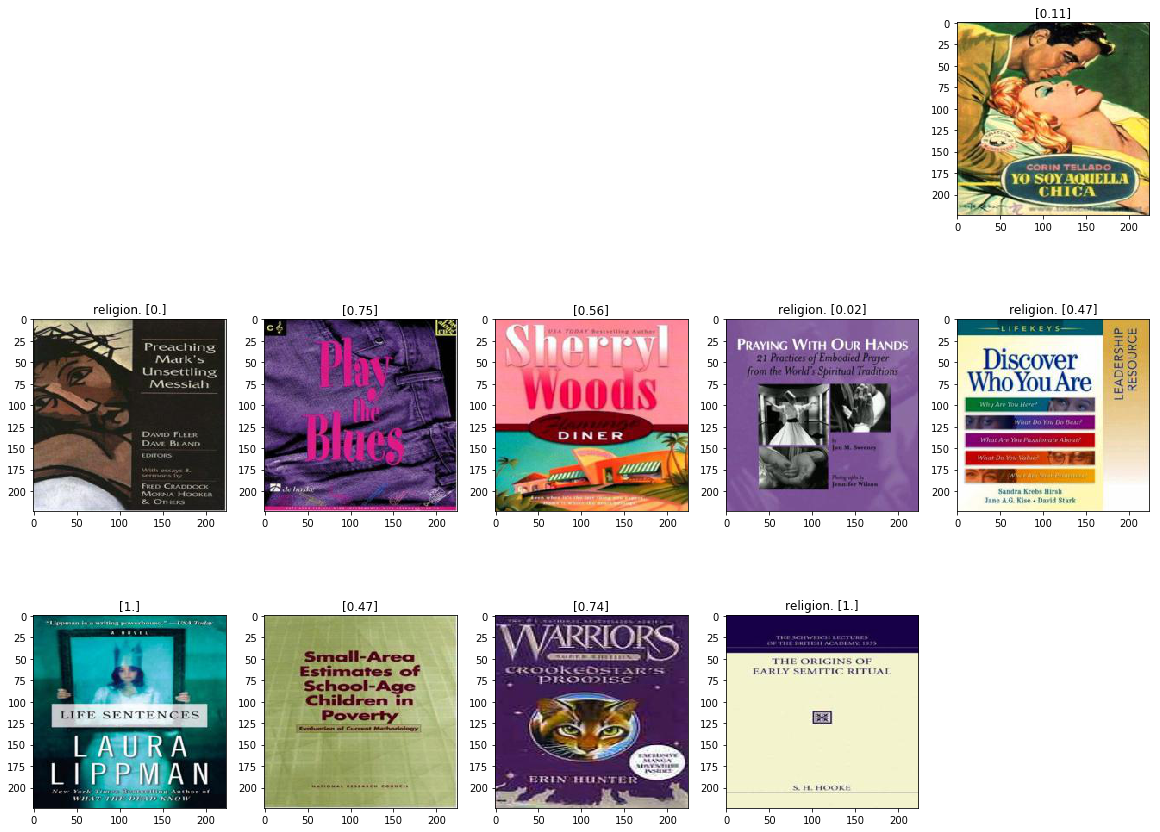

In [77]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    book_title = ()
    if ytr[i] !=0:
        book_title = 'religion. '+ str(np.around(pred[i],decimals= 2))
    else:
        book_title = str(np.around(pred[i], decimals = 2))
    subplot.set_title(book_title); # поправить вывод названия
    
plt.show()

In [58]:
pred_class = np.around(pred)
pred_class

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [82]:
from sklearn.metrics import *
import sklearn as skl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

summary = classification_report(ytst, pred_class)
print(summary)

             precision    recall  f1-score   support

        0.0       0.63      0.66      0.64      1515
        1.0       0.64      0.60      0.62      1513

avg / total       0.63      0.63      0.63      3028



In [84]:
pred

array([[9.9215746e-01],
       [5.5391436e-05],
       [7.5175065e-01],
       ...,
       [8.5255915e-01],
       [6.3263327e-01],
       [7.5781834e-01]], dtype=float32)

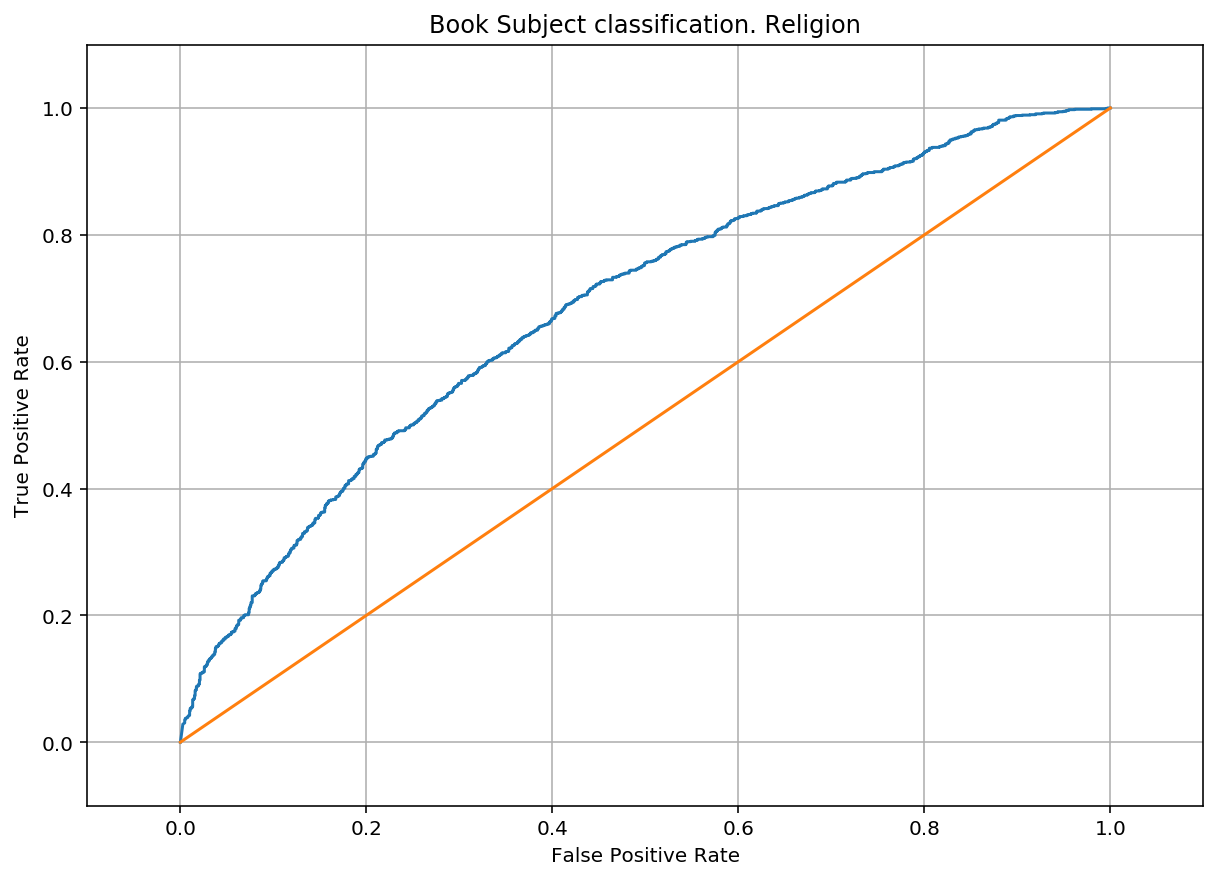

In [96]:
fpr, tpr, thresholds = roc_curve(ytst, pred)
fig = plt.figure()
plt.plot( fpr, tpr)    
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Book Subject classification. Religion')
plt.grid()
plt.show()
fig.savefig('Book Subject classification LSTM', dpi = 300, bbox_inches='tight')
print();